**Librerias**

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
import pandas as pd
from utils.data import divideData
from utils.model import tuneHyperparameters
from utils.evaluate import modelEvaluation, modelEvaluationWithThreshold
import joblib
import warnings
warnings.filterwarnings('ignore')

**Cargar datos procesados**

In [2]:
df =  pd.read_excel("../data/processed/REPORTE_RECORD_ESTUDIANTIL_ANONIMIZADO.xlsx")

Definir las caracteristicas de las que el modelo aprenderá

In [3]:
features = [
    'PROM_PERIODO',
    'ASIST_PROM',
    'TOTAL_MAT',
    'REPROBADAS',
    'REPITENCIAS',
    'NIVEL', 
    'PROP_REPROB'
    ]

**División de datos en `train/test`**

La partición de los datos se realizó respetando el orden temporal de los períodos académicos, utilizando los ciclos más antiguos para entrenamiento y los más recientes para prueba, con el fin de simular un escenario real de predicción y evitar sesgos por fuga de información.

In [4]:
X_train, X_test, y_train, y_test = divideData(df, features)

# Modelo

**Ramdon Forest**

In [5]:
rf = tuneHyperparameters(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'smote__sampling_strategy': 'not majority', 'smote__k_neighbors': 3, 'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 5, 'rf__max_features': 'log2', 'rf__max_depth': 9, 'rf__criterion': 'gini'}
Best F1 macro: 0.7914


In [6]:
rf.fit(X_train, y_train)

Pipeline(steps=[('smote',
                 SMOTE(k_neighbors=3, random_state=42,
                       sampling_strategy='not majority')),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        max_features='log2', min_samples_leaf=5,
                                        n_estimators=200, random_state=42))])

CV ROC-AUC: 80.25%
CV Accuracy: 81.59%
Test ROC-AUC: 81.42%
Test Accuracy: 94.08%
Balanced Accuracy: 55.56%

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       144
           1       0.33      0.12      0.18         8

    accuracy                           0.94       152
   macro avg       0.64      0.56      0.58       152
weighted avg       0.92      0.94      0.93       152



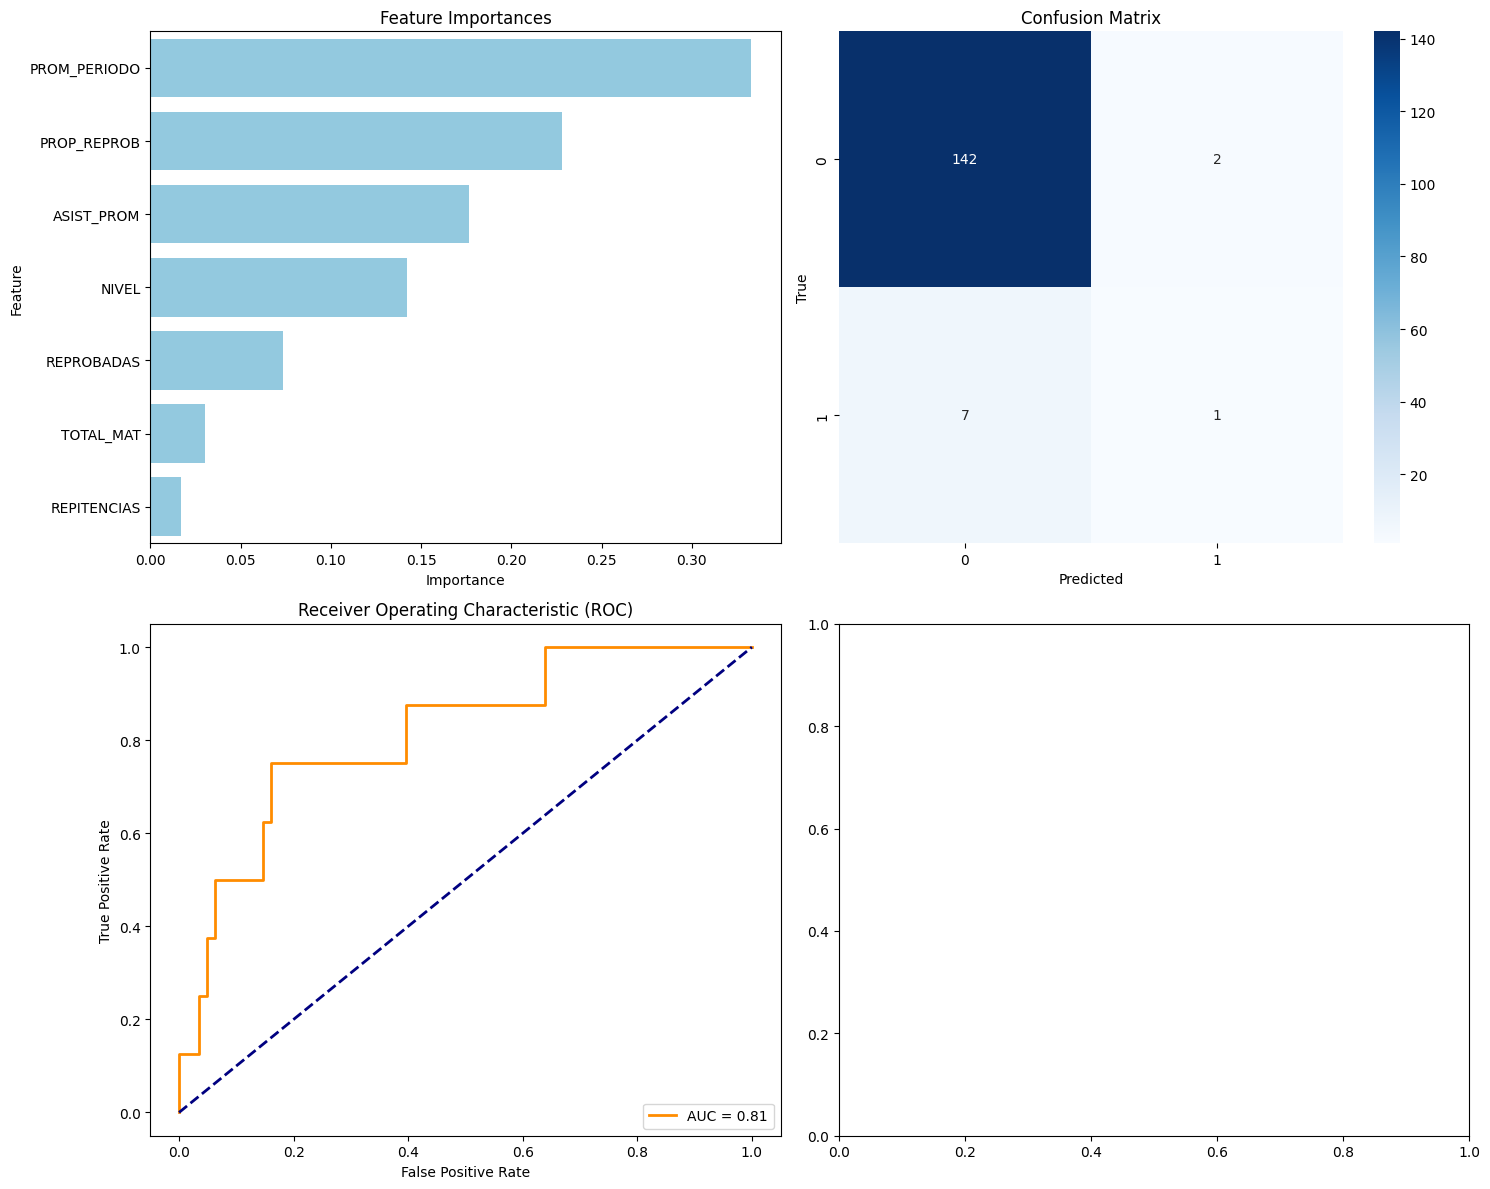

In [7]:
modelEvaluation(rf, df[features], df['RIESGO_t1'], X_test, y_test)

Aunque el modelo presenta una alta exactitud global, esta métrica resulta engañosa debido al fuerte desbalance de clases. El bajo recall de la clase minoritaria evidencia que el modelo, en su configuración inicial, prioriza la correcta clasificación de estudiantes no desertores, sacrificando la detección temprana de casos de deserción. Sin embargo, el valor del ROC-AUC indica una adecuada capacidad discriminativa, lo que sugiere que el problema no radica en el aprendizaje del patrón, sino en la definición del umbral de decisión.

# Threshold

En una primera etapa se evaluó el modelo utilizando el umbral de decisión estándar (0.5), observándose una alta exactitud global pero una baja capacidad de detección de la clase minoritaria. Posteriormente, se ajustó el umbral de decisión utilizando la curva Precision–Recall, sin reentrenar el modelo, priorizando el recall de la deserción estudiantil.

In [8]:
y_proba = rf.predict_proba(X_test)[:, 1]

Selected threshold: 0.22

Recall (dropout): 0.75
Precision: 0.21
F1-score: 0.32
Balanced Accuracy: 0.80
ROC-AUC: 0.81

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       144
           1       0.21      0.75      0.32         8

    accuracy                           0.84       152
   macro avg       0.60      0.80      0.62       152
weighted avg       0.94      0.84      0.88       152



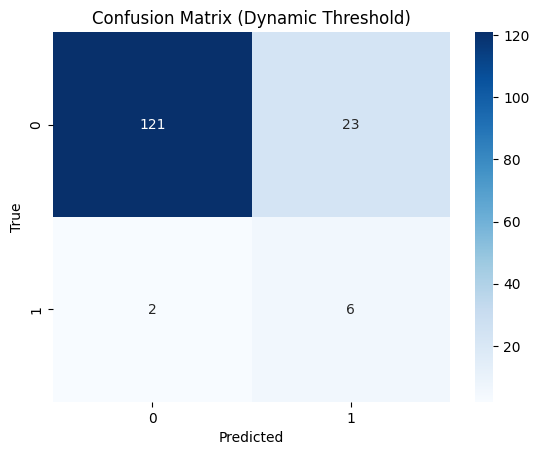

In [11]:
best_threshold = modelEvaluationWithThreshold(rf, X_train, y_train, X_test, y_test)

El ajuste del umbral de decisión permitió priorizar la detección de estudiantes en riesgo, incrementando significativamente el recall de la clase minoritaria, con un impacto controlado en la precisión. Esta estrategia resulta coherente con el contexto educativo, donde el costo de falsos negativos supera ampliamente al de falsos positivos.

# Guardar modelo + threshold

In [14]:
modelArtifact = {
    'model': rf,
    'threshold': best_threshold
}

joblib.dump(modelArtifact, '../models/dropout_rf_threshold02_v1.joblib')

['../models/dropout_rf_threshold02_v1.joblib']

El modelo entrenado y el umbral de decisión fueron almacenados conjuntamente como un único artefacto, permitiendo desacoplar el proceso de entrenamiento del proceso de inferencia. Esta estrategia garantiza la reproducibilidad de las predicciones y facilita la adaptación del sistema a distintos escenarios institucionales sin necesidad de reentrenar el modelo.